Questa è l'ultima versione del codice per la classificazione di MNIST con uno Stochastic Quantum Walker.
L'unico pacchetto "non-standard" è torchdiffeq, la cui funzione odeint_adjoint risolve equazioni differenziali utilizzando O(1) di memoria per la backpropagation.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import math
from torchdiffeq import odeint_adjoint as odeint

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


I dataset sono caricati nei dataloader. MNIST è già encodato a 64 feature e paddato con gli ultimi 10 pixel pari a 0. Da notare che le immagini sono già in formato torch.complex64. Inoltre, nel notebook dell'autoencoder, l'encoder ha come ultimo layer una ReLU e non una sigmoide! Questo significa che i pixel non hanno più valori compresi tra 0 e 1. La ragione di questa scelta è perché nel caso della sigmoide, e al contrario della ReLU, il training non riusciva (non so bene perché) a ottimizzare a sufficienza e la loss rimaneva alta.

In [3]:
class StochasticMNIST(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Carico le immagini encodate
train_data, train_targets = torch.load("qsw_train_data_encoded64.pt", weights_only=False)
test_data, test_targets = torch.load("qsw_test_data_encoded64.pt", weights_only=False)

# Creo i dataset
qsw_train_data = StochasticMNIST(train_data, train_targets)
qsw_test_data = StochasticMNIST(test_data, test_targets)

batch_size = 128

qsw_train_dataloader = DataLoader(qsw_train_data, batch_size=batch_size, shuffle=True, num_workers=32)
qsw_test_dataloader = DataLoader(qsw_test_data, batch_size=batch_size, shuffle=True, num_workers=32)

for X, y in qsw_train_dataloader:
    print(f'Dimensioni dataset: {X.shape}, {y.shape}')
    print(f'Data type: {X.dtype}, {y.dtype}')
    print(f'Padding: {X[0,-10:]}')
    break

Dimensioni dataset: torch.Size([128, 74]), torch.Size([128])
Data type: torch.complex64, torch.int64
Padding: tensor([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])


Definisco la classe SQWalker del modello e la classe LindbladFunc. Quest'ultima è necessaria per implementare correttamente la funzione odeint_adjoint. In altre parole, dato il problema di Cauchy

dy/dt = f(t, y)    y(t_0) = y_0.

odeint_adjoint(func, y0, t) necessita che func sia un nn.Module.

In [4]:
class LindbladFunc(nn.Module):
    def __init__(self, N, s, l, p, device):
        self.factory_kwargs = {"device": device, "dtype": torch.complex64}
        super().__init__()
        # Inizializzo i parametri del modello.
        self.n = math.isqrt(N)
        self.N = N
        self.s = s
        self.p = p

        # Costruisco la matrice di transizione e la popolo con i pesi da trainare.
        # Per semplicità scelgo i primi 10 nodi come quelli collegati ai sink.
        self.sinkrates = nn.parameter.Parameter(
            torch.empty((1, self.s), requires_grad=True, **self.factory_kwargs)
        )
        self.mask_sinks = torch.zeros((self.s, self.N), **self.factory_kwargs)
        self.mask_sinks.fill_diagonal_(1)

        # Costruisco dei tensori ausiliari per l'integrazione.
        self.B = torch.zeros(self.N + self.s, self.N + self.s, **self.factory_kwargs)
        self.B[:self.N, :self.N] = 0.5 * self.p * torch.eye(self.N, **self.factory_kwargs)

        # Costruisco la matrice del lattice e la popolo con i pesi da trainare.
        self.mask = self._create_mask(l, device)
        self.expressivity = torch.count_nonzero(self.mask)
        self.weights = nn.parameter.Parameter(
            torch.empty((1, self.expressivity), requires_grad=True, **self.factory_kwargs)
        )
        self.reset_parameters()
        
    def _create_mask(self, l, device):
        '''Restituisce una maschera per le entrate non nulle di una matrice di adiacenza di un lattice.
        Non saprei dire quanto sia efficiente, ma è il modo più carino che mi è venuto in mente.
        
        Parametri
        ---------
        l : int tra 1 e n-1, dove n è la dimensione dell'immagine (es. per MNIST non encodato n=28)

        Ritorna
        -------
        torch.tensor con dtype = torch.bool
        '''
        # Il tensore moves determina la struttura della cella a l-vicini.
        moves = torch.ones(2*l+1, 2*l+1, device=device)
        moves[l,l] = 0

        M = nn.functional.pad(moves, (self.n-l-1, self.n-l-1, self.n-l-1, self.n-l-1), 'constant', 0)

        m = torch.zeros((self.N, self.N), device=device)
        for i in range(self.n):
            for j in range(self.n):
                m[i*self.n+j] = M[self.n-1-i:2*self.n-1-i, self.n-1-j:2*self.n-1-j].flatten()
        return m == 1
    
    def reset_parameters(self):
        # Impostare a=sqrt(5) in kaiming_uniform equivale a inizializzare con
        # uniform(-1/sqrt(n_features), 1/sqrt(n_features)).
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.sinkrates, a=math.sqrt(5))

    def update_walker(self):
        '''Aggiorna i tensori nell'eq. di Lindblad'''
        
        # Definisco le matrici A e gamma.
        self.A = torch.zeros((self.N, self.N), **self.factory_kwargs)
        self.A[self.mask] = self.weights
        self.A = self.A - 1j * self.A.imag
        self.A = 0.5*(self.A + self.A.T)**2

        self.gamma = torch.zeros((self.s, self.N), **self.factory_kwargs)
        self.gamma[self.mask_sinks == 1] = self.sinkrates
        self.gamma = self.gamma - 1j * self.gamma.imag
        self.gamma = (self.gamma)**2

        # Calcolo le connettività della matrice A.
        degA = torch.sum(self.A, dim=0) 
            
        # Aggiorno la laplaciana.
        self.laplacian = torch.zeros(self.N + self.s, self.N + self.s, **self.factory_kwargs)
        self.laplacian[:self.N, :self.N] = self.p * self.A / degA
        self.laplacian[self.N:, :self.N]= self.gamma

        # Calcolo la matrice a del foglio LaTeX.
        R = torch.zeros(self.N + self.s, self.N + self.s, **self.factory_kwargs)
        R[self.N:, :self.N] = self.gamma
        self.a = 0.5 * torch.diag(torch.sum(R, dim=0)) + self.B

        # Aggiorno l'hamiltoniana.
        self.H = torch.eye(self.N + self.s, **self.factory_kwargs)
        self.H[:self.N, :self.N] = (1 - self.p) * self.A
    
    def forward(self, t, rho):
        '''Metodo che viene chiamato da odeint durante l'integrazione.
        Calcola l'rhs dell'eq. di Lindblad
        '''
        drho = -1j * (torch.matmul(self.H, rho) - torch.matmul(rho, self.H))
        drho = drho + torch.diag_embed(torch.matmul(torch.diagonal(rho, dim1 = 1, dim2 = 2), self.laplacian.T))
        drho = drho - (torch.matmul(self.a, rho) + torch.matmul(rho, self.a))
        return drho
    
    def extra_repr(self) -> str:
        return "in_features: {a}, out_features: {b}\n Expressivity: {c:.2f}%".format(a = self.N, b = self.s, c = self.expressivity*100/self.N**2)

class SQWalker(nn.Module):
    '''Classe dello Stochastic Quantum Walker'''
    def __init__(self, in_features, out_features, dt=1e-3, steps=1000, l = 1, noise=1., device = None):
        super().__init__()
        self.s = out_features
        self.lindblad = LindbladFunc(in_features, out_features, l, noise, device)
        self.t = torch.arange(steps+1, device=device)*dt
        
    def forward(self, input, history = False, method = 'rk4'):
        '''
        Parametri
        ---------
        
        Ritorna
        -------
        se history=False
            output.real: torch.tensor di shape (batch_size, s) che contiene il valore dei sink nello stato finale
        se history = True
            result: torch.tensor di shape (batch, steps, n, n) che contiene il valore di rho a tutti gli istanti.
            '''
        self.lindblad.update_walker()

        # Costruisco la matrice densità iniziale popolando la diagonale con l'immagine.
        rho0 = torch.diag_embed(input)
        
        # Integro con Runge-Kutta al quart'ordine. Se method non fosse specificato,
        # odeint userebbe il metodo Dormand-Price (Runge-Kutta adattivo di ordine 5).
        result = odeint(self.lindblad, y0=rho0, t=self.t, method = method)

        if history == True:
            return result
        output = result[-1].diagonal(dim1=-2, dim2=-1)[:, -self.s:]
        
        return output.real

Definisco il modello, indicando la dimensione di input e di output, i parametri dell'integrazione, il passo del lattice e il noise. La scelta di mettere dt=1. sembra pareccchio azzardata. Vedremo a posteriori che l'integrazione lavora comunque a modo. Il vantaggio è ovvio: se la cosa è lecita, bastano pochissimi passi e il training viene eseguito in un tempo ragionevole. 

In [5]:
model = SQWalker(64, 10, dt = 1., steps = 50, l = 2, noise = 0.2, device = device).to(device)
print(model)

SQWalker(
  (lindblad): LindbladFunc(
    in_features: 64, out_features: 10
     Expressivity: 26.66%
  )
)


In [6]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
def train(dataloader, model, loss_fn, optimizer, voice = True):
    size = len(dataloader.dataset)
    model.train()
    current = 0
    i = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        current += len(X)

        if current >= i*10000 and voice:
            i += 1
            loss = loss.item()
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct, test_loss

In [9]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(qsw_train_dataloader, model, loss_fn, optimizer)
    test(qsw_test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 6.976196  [  128/60000]
loss: 2.359960  [10112/60000]
loss: 2.358345  [20096/60000]
loss: 2.366081  [30080/60000]
loss: 2.315771  [40064/60000]
loss: 2.269418  [50048/60000]
loss: 2.164721  [60000/60000]
Test Error: 
 Accuracy: 17.4%, Avg loss: 2.196330 

Epoch 2
-------------------------------
loss: 2.200248  [  128/60000]
loss: 2.095577  [10112/60000]
loss: 1.962765  [20096/60000]
loss: 1.870384  [30080/60000]
loss: 1.814348  [40064/60000]
loss: 1.852032  [50048/60000]
loss: 1.750075  [60000/60000]
Test Error: 
 Accuracy: 38.0%, Avg loss: 1.786620 

Epoch 3
-------------------------------
loss: 1.753733  [  128/60000]
loss: 1.755722  [10112/60000]
loss: 1.632880  [20096/60000]
loss: 1.677761  [30080/60000]
loss: 1.664694  [40064/60000]
loss: 1.707820  [50048/60000]
loss: 1.685152  [60000/60000]
Test Error: 
 Accuracy: 41.6%, Avg loss: 1.659997 

Epoch 4
-------------------------------
loss: 1.834330  [  128/60000]
loss: 1.667251  [10112/6

In [10]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [14]:
model = SQWalker(64, 10, dt = 1., steps = 100, l = 2, noise = 0.2, device = device).to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

Verifichiamo adesso che l'integrazione non crei problemi. Per farlo, prendiamo una immagine a caso e effettuiamo l'integrazione sia col metodo rk4, sia chiamando il metodo dopri5 (Dormand-Price). Quest'ultimo è un metodo adattivo che sceglie autonomamente il passo d'integrazione: i valori di dt e steps rappresentano allora soltanto gli istanti per i quali odeint deve restituire il valore di rho, ma non cambiano la precisione dell'integrazione.
Quando avevo fatto questa operazione per il caso full connected, mi ero reso conto che solo per dt molto piccoli le integrazioni combaciavano. In questo caso invece, per dt=1 lo stato finale è identico per i due metodi. C'era poi un altro problema che mi aveva portato a concludere che dt dovesse essere molto piccolo, ma era un errore di codice che poi vi spiegherò a voce.

In [15]:
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

model.eval()
n_datas = len(test_data)

c = torch.randint(n_datas,(1,)).item()
x, y = qsw_test_data[c]
with torch.no_grad():
    x = x.to(device)
    pred = model(x.unsqueeze(0), history=True).squeeze(1)
    sinks = pred[-1].diagonal(dim1=-2, dim2=-1)[-10:].real
    
    pred_real = model(x.unsqueeze(0), history=True, method = 'dopri5').squeeze(1)
    sinks_real = pred_real[-1].diagonal(dim1=-2, dim2=-1)[-10:].real

    predicted, actual = classes[sinks.argmax()], classes[y]

# Stampo la percentuale del valore totale dei pixel che è finito nei sink
print(f'Convergenza: {(100*torch.sum(sinks)/torch.sum(x.real)):.2f}%')

# Confronto i due stati finali nei sink
print(f'Stato finale rk4: {sinks}\nStato finale reale: {sinks_real}')

# Confronto i due stati finali anche per le entrate off-diagonal. Probabilmente qua verrà False.
# Tuttavia nella prossima cella ci accorgiamo comunque che le differenze sono minime
print(torch.allclose(pred[-1], pred_real[-1]))

Convergenza: 77.68%
Stato finale rk4: tensor([19.0231, 19.3966, 17.9123, 18.9633, 24.2981, 34.5946, 29.2684, 24.4562,
        18.9291, 30.4236], device='cuda:0')
Stato finale reale: tensor([19.0231, 19.3966, 17.9123, 18.9633, 24.2981, 34.5946, 29.2684, 24.4562,
        18.9291, 30.4236], device='cuda:0')
True


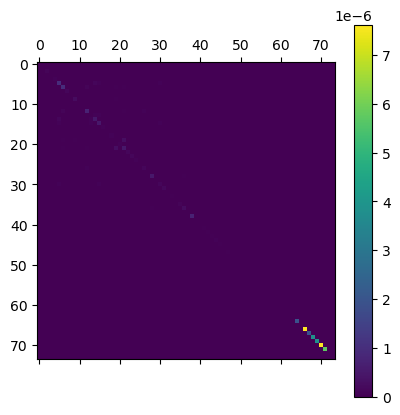

In [16]:
plt.matshow(torch.abs(pred[-1] - pred_real[-1]).cpu().numpy())
plt.colorbar()
plt.show()